In [1]:
from thejoker.data import RVData
from thejoker.sampler import JokerParams, TheJoker
from thejoker.plot import plot_rv_curves
import astropy.units as u
import schwimmbad
import numpy as np
import matplotlib.pyplot as plt

t, rv, err = np.loadtxt('data/kic6780873_JDrv.txt', usecols=(0,1,2), delimiter=',').T
# t, rv, err = np.loadtxt('data/kic10080943a_JDrv.txt', delimiter=',', usecols=(0,1,2)).T
t -= t[0]
rv *= u.km/u.s
err *= u.km/u.s 

INFO: 1 good sample after rejection sampling [thejoker.sampler.sampler]


Text(0, 0.5, '$K$ [km/s]')

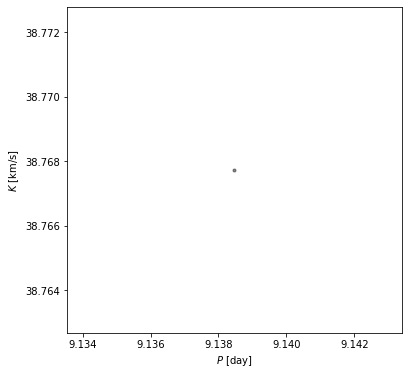

In [2]:
data = RVData(t=t, rv=rv, stddev=err)
params = JokerParams(P_min=5*u.day, P_max=200*u.day)
pool = schwimmbad.MultiPool()
joker = TheJoker(params, pool=pool)

samples = joker.rejection_sample(data, n_prior_samples=100000)

fig, ax = plt.subplots(1, 1, figsize=(6,6)) # doctest: +SKIP
ax.scatter(samples['P'].value, samples['K'].to(u.km/u.s).value,
           marker='.', color='k', alpha=0.45) # doctest: +SKIP
ax.set_xlabel("$P$ [day]")
ax.set_ylabel("$K$ [km/s]")

In [3]:
samples

JokerSamples([('P', <Quantity [9.13846644] d>),
              ('M0', <Quantity [5.28988529] rad>),
              ('e', <Quantity [0.13281593]>),
              ('omega', <Quantity [3.28809424] rad>),
              ('jitter', <Quantity [0.] km / s>),
              ('K', <Quantity [38.76774172] km / s>),
              ('v0', <Quantity [17.16181821] km / s>)])

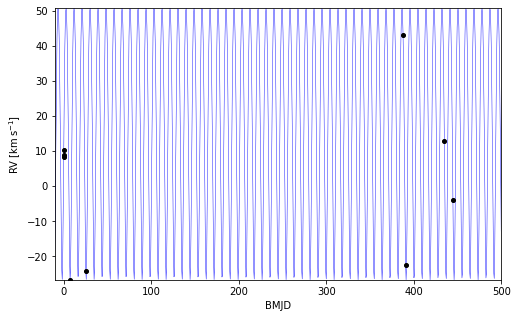

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
t_grid = np.linspace(-10, 500, 1024)
plot_rv_curves(samples[:100], t_grid, rv_unit=u.km/u.s, data=data, ax=ax,
               plot_kwargs=dict(color='blue'));

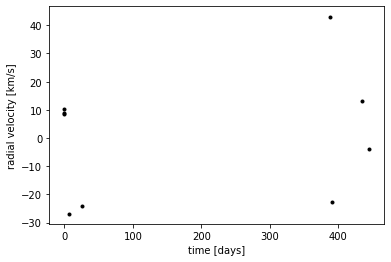

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

x = t
y = rv.value
# y -= np.mean(y)
yerr = err.value

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [km/s]");

In [26]:
import exoplanet as xo

period = samples['P'].value
period_err = [0.1]
t0s = [0]
t0_errs = [0.0007]
Ks = samples['K'].value

In [38]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    t0 = pm.Uniform('t0', lower=10, upper=100, testval=20)
    P = pm.Bound(pm.Normal, lower=0)("P", mu=period, sd=0.1,
                                     shape=1, testval=period)

    # Wide log-normal prior for semi-amplitude
    logK = pm.Bound(pm.Normal, lower=0)("logK", mu=np.log(Ks), sd=10.0,
                                        shape=1, testval=np.log(Ks))

    # Eccentricity & argument of periasteron
    ecc = xo.distributions.UnitUniform("ecc", shape=1, testval=0.1)
    omega = xo.distributions.Angle("omega", shape=1)

    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)

    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(
        period=P, t0=t0,
        ecc=ecc, omega=omega)
    t_per = pm.Deterministic('t_per', orbit.t_periastron)
    vrad = orbit.get_radial_velocity(x, K=tt.exp(logK))
    
    # Define the background model
    trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=1)
    A = np.vander(x - 0.5*(x.min() + x.max()), 1)
    bkg = pm.Deterministic("bkg", tt.dot(A, trend))
#     bkg = pm.Uniform('gammav', lower=-50, upper=50, testval=-12)
    rv_model = pm.Deterministic("rv_model", vrad + bkg)
    
    err = tt.sqrt(yerr**2 + tt.exp(2*logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)

In [39]:
t = np.linspace(x.min()-5, x.max()+5, 1000)

with model:
    vrad_pred = orbit.get_radial_velocity(t, K=tt.exp(logK))
    pm.Deterministic("vrad_pred", vrad_pred)

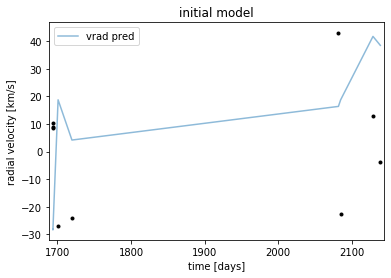

In [40]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(x, xo.eval_in_model(rv_model), alpha=0.5, label='vrad pred')
#     plt.plot(t, xo.eval_in_model(vrad_pred), alpha=0.5, label='vrad pred')
plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [km/s]")
plt.title("initial model");

In [41]:
with model:
    map_soln = xo.optimize(start=model.test_point)
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [trend, logs, omega, ecc, logK, P, t0]
119it [00:00, 194.80it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -85967.18089352128 -> nan
optimizing logp for variables: [trend, logs, omega, ecc, logK, P, t0]
119it [00:00, 204.69it/s, logp=nan]        
message: Desired error not necessarily achieved due to precision loss.
logp: -85967.18089352128 -> nan


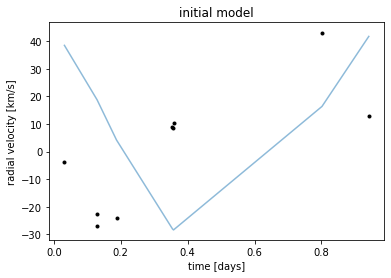

In [42]:

plt.errorbar(x % map_soln['P'] / map_soln['P'], y, yerr=yerr, fmt=".k")

with model:
    x_sort = x % map_soln['P'] / map_soln['P']
    sort = np.argsort(x_sort)
    plt.plot(x_sort[sort], xo.eval_in_model(rv_model, map_soln)[sort], alpha=0.5)
plt.xlabel("time [days]")
plt.ylabel("radial velocity [km/s]")
plt.title("initial model");

In [15]:
np.random.seed(42)
with model:
    trace = pm.sample(tune=2000, draws=1000, step=xo.get_dense_nuts_step(target_accept=0.95))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [gammav, logs, omega, ecc, logK, P, t0]
Sampling 2 chains: 100%|██████████| 6000/6000 [01:29<00:00, 66.96draws/s] 
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8953883521587498, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [16]:
pm.summary(trace, varnames=["logs", "omega", "ecc", "t0", "logK", "P", 'gammav'])


/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logs,0.001343,0.428762,0.025099,-0.818010,0.922069,240.801436,1.000681
omega__0,-0.463536,0.624621,0.032669,-2.050614,0.114008,296.568564,0.999604
ecc__0,0.161437,0.095867,0.006949,0.001282,0.334989,106.588369,1.009128
t0,3.882290,0.651258,0.047220,2.606872,4.960177,116.936504,1.004390
logK__0,3.695158,0.052402,0.002543,3.585444,3.790814,318.210849,1.002565
P__0,9.170763,0.015067,0.001069,9.146600,9.200746,126.943021,1.005001
gammav,7.154889,5.927493,0.406797,-4.281536,17.612547,142.560440,1.004688


In [17]:
(9.188756 * 86400) * np.sqrt(1 - 0.265552**2) * (40.18097778 * 1000) / (2*np.pi) / 299792458



16.327170007217493

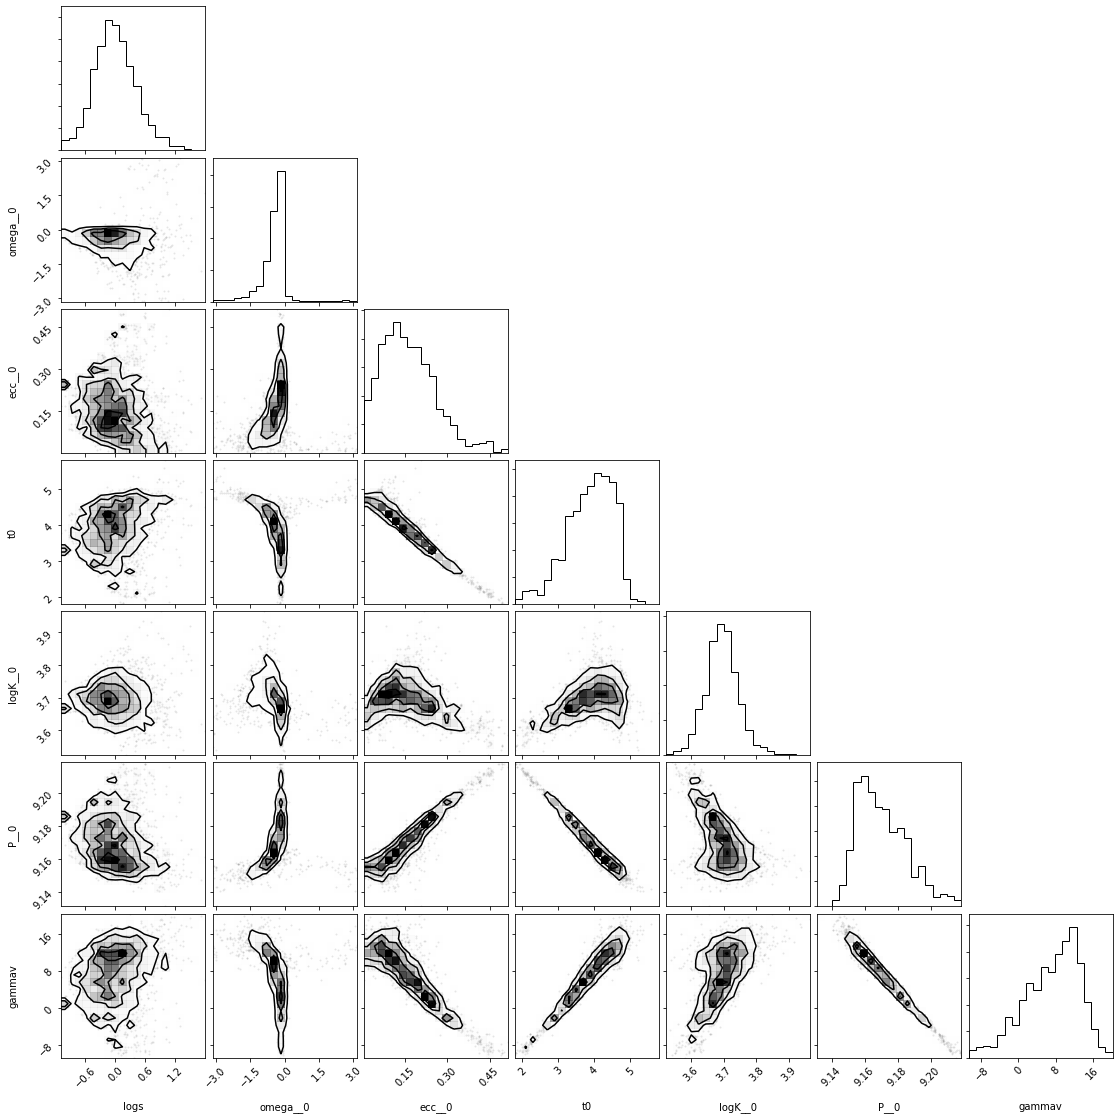

In [18]:
import corner

corner.corner(pm.trace_to_dataframe(trace, varnames=["logs", "omega", "ecc", "t0", "logK", "P", 'gammav']));

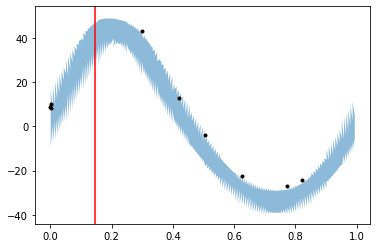

In [19]:
med = np.mean(trace['vrad_pred'], axis=0)
sd = np.std(trace['vrad_pred'], axis=0)
t = np.linspace(x.min()-5, x.max()+5, 1000)


times = t % np.mean(trace['P']) / np.mean(trace['P'])
sort = np.argsort(times)
plt.fill_between(times[sort], (med-sd)[sort], (med+sd)[sort], alpha=0.5)

plt.errorbar(x % np.mean(trace['P']) / np.mean(trace['P']), y, yerr=yerr, fmt=".k")
plt.axvline(0.1457, c='r')

Text(0, 0.5, 'RV [km/s]')

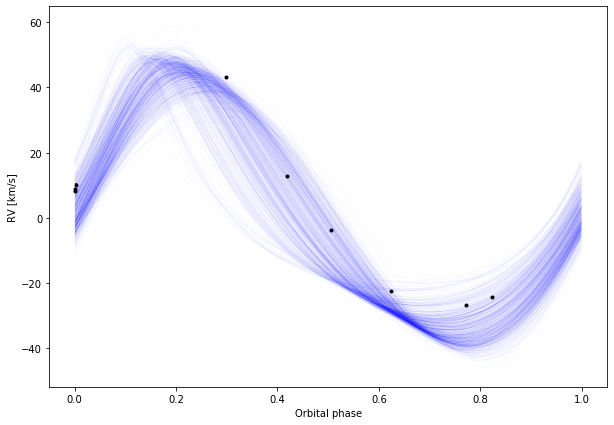

In [20]:
plt.figure(figsize=[10,7])

with model:
    for sample in xo.get_samples_from_trace(trace, 1000):
        
        tt = t % sample['P'] / sample['P']
        sort = np.argsort(tt)
        plt.plot(tt[sort], sample['vrad_pred'][sort], alpha=0.1, label='vrad pred', linewidth=0.1, c='blue')
        
plt.errorbar(x % np.mean(trace['P']) / np.mean(trace['P']), y, yerr=yerr, fmt=".k")

plt.xlabel('Orbital phase')
plt.ylabel('RV [km/s]')

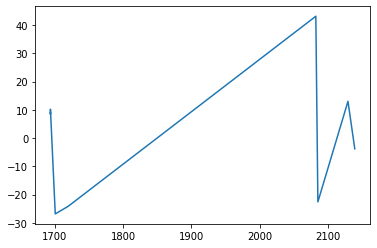

In [43]:
x, y, yerr = np.loadtxt('data/kic6780873_JDrv.txt', usecols=(0,1,2), delimiter=',').T
x += 2400000
x -= 2454833
plt.plot(x,y)

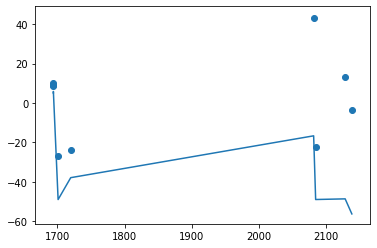

In [44]:
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    P = pm.Bound(pm.Normal, lower=0)("P", mu=period, sd=1,
                                     shape=1, testval=period)

    # Wide log-normal prior for semi-amplitude
    logasini = pm.Bound(pm.Normal, lower=0)("logasini", mu=np.log(18), sd=10.0,
                                        shape=1, testval=np.log(18))
    asini = pm.Deterministic('asini', tt.exp(logasini))
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    # Eccentricity & argument of periasteron
    ecc = xo.distributions.UnitUniform("ecc", shape=1, testval=0.01)
    omega = xo.distributions.Angle("omega", shape=1)
    gammav = pm.Uniform('gammav', lower=-50, upper=50, testval=-13)
    
#     t0 = pm.Normal('t0', mu=0., sd=10, testval=0.1)    
#     sinw = tt.sin(omega)
#     cosw = tt.cos(omega)
#     opsw = 1 + sinw
#     E0 = 2 * tt.arctan2(tt.sqrt(1-ecc)*cosw, tt.sqrt(1+ecc)*opsw)
#     M0 = E0 - ecc * tt.sin(E0)
#     tref = pm.Deterministic("tref", t0 - M0 * P / (2*np.pi))
    
#     # Mean anom
#     M = 2.0 * np.pi * (x - tref) / P

    phi = xo.distributions.Angle('phi', testval=0.23)
    M = 2. * np.pi * x / P - phi
    # True anom
    f = get_true_anomaly(M, ecc + tt.zeros_like(M))
    vrad = -2.0 * np.pi * ((tt.exp(logasini) / 86400) / P) * (1/tt.sqrt(1.0 - tt.square(ecc))) * (tt.cos(f + omega) + ecc*tt.cos(omega))
    vrad *= 299792.458  # c in km/s
    vrad += gammav # Systemic velocity
    err = tt.sqrt(2*yerr**2 + tt.exp(2*logs))
    pm.Normal("obs", mu=vrad, sd=err, observed=y)
    
    plt.plot(x, xo.eval_in_model(vrad))
    plt.scatter(x, y)
    
    
t = np.linspace(x.min()-5, x.max()+5, 1000)
with model:
    M2 = 2. * np.pi * t / P - phi
    f2 = get_true_anomaly(M2, ecc + tt.zeros_like(M2))
    vrad2 = -2.0 * np.pi * ((tt.exp(logasini) / 86400) / P) * (1/tt.sqrt(1.0 - tt.square(ecc))) * (tt.cos(f2 + omega) + ecc*tt.cos(omega))
    vrad2 *= 299792.458  # c in km/s|
    vrad2 += gammav # Systemic velocity
    pm.Deterministic("vrad_pred", vrad2)

In [13]:
with model:
    map_soln = xo.optimize(start=model.test_point)
    map_soln = xo.optimize(start=map_soln, vars=[gammav])
    map_soln = xo.optimize(start=map_soln, vars=[phi])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [phi, gammav, omega, ecc, logs, logasini, P]
566it [00:02, 266.68it/s, logp=9.202458e+00] 
message: Desired error not necessarily achieved due to precision loss.
logp: -66052.26218214087 -> 9.202458259984706
optimizing logp for variables: [gammav]
5it [00:00, 26.43it/s, logp=9.202458e+00] 
message: Optimization terminated successfully.
logp: 9.202458259984706 -> 9.20245825998473
optimizing logp for variables: [phi]
3it [00:00, 17.36it/s, logp=9.202458e+00] 
message: Optimization terminated successfully.
logp: 9.20245825998473 -> 9.20245825998473
optimizing logp for variables: [phi, gammav, omega, ecc, logs, logasini, P]
63it [00:00, 149.39it/s, logp=7.513533e+00] 
message: Desired error not necessarily achieved due to precision loss.
logp: 9.20245825998473 -> 9.20245825998473


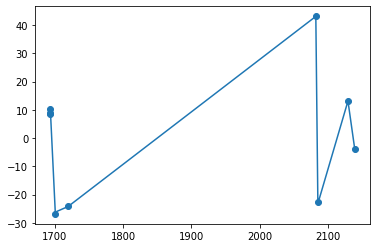

In [14]:
with model:
    plt.scatter(x,y)
    plt.plot(x, xo.eval_in_model(vrad,map_soln))

Text(0, 0.5, 'RV')

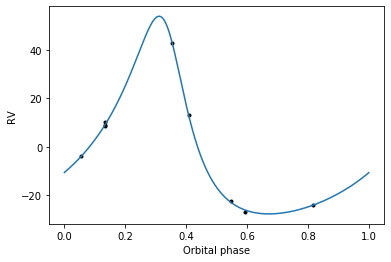

In [15]:
with model:
    plt.plot(x % map_soln['P'] / map_soln['P'],y, '.k')
    t_fold = t % map_soln['P'] / map_soln['P']
    sort = np.argsort(t_fold)
    plt.plot(t_fold[sort], xo.eval_in_model(vrad2,map_soln)[sort])
    
plt.xlabel('Orbital phase')
plt.ylabel('RV')


In [17]:
map_soln

{'P_lowerbound__': array([2.73307554]),
 'logasini_lowerbound__': array([1.18074269]),
 'logs': array(-1.09381796),
 'ecc_logodds__': array([-0.25400231]),
 'omega_angle__': array([[-2.08997617],
        [-3.95373237]]),
 'gammav_interval__': array(-0.10771974),
 'phi_angle__': array([ 3.78989023, -2.37418026]),
 'P': array([15.38011646]),
 'logasini': array([3.25679211]),
 'asini': array([25.96610686]),
 'ecc': array([0.43683864]),
 'omega': array([-2.65532112]),
 'gammav': array(-2.69039244),
 'phi': array(2.13043833),
 'vrad_pred': array([-2.45667620e+01, -2.31483760e+01, -2.14920216e+01, -1.95884742e+01,
        -1.74201736e+01, -1.49604928e+01, -1.21723305e+01, -9.00594361e+00,
        -5.39591483e+00, -1.25723603e+00,  3.51910201e+00,  9.06928230e+00,
         1.55527934e+01,  2.31238334e+01,  3.18271285e+01,  4.12865732e+01,
         4.99481967e+01,  5.40300588e+01,  4.87293915e+01,  3.43216740e+01,
         1.73891668e+01,  3.10855342e+00, -7.37588762e+00, -1.46964233e+01,
    

In [72]:
%run paper/setup.py

In [19]:
np.random.seed(42)
with model:
    trace = pm.sample(tune=1000, draws=1000, step=xo.get_dense_nuts_step(target_accept=0.95), start=map_soln)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [phi, gammav, omega, ecc, logs, logasini, P]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:32<00:00, 124.90draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [20]:
pm.summary(trace)

/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logs,-0.181560,0.536623,0.025878,-1.162858,0.841097,344.179469,1.000533
P__0,15.380249,0.004645,0.000197,15.370246,15.389918,558.635751,1.000910
logasini__0,3.257560,0.048012,0.001758,3.163309,3.356935,689.790003,1.000167
asini__0,26.016400,1.277918,0.045932,23.648721,28.701097,730.356429,1.000194
ecc__0,0.438763,0.018935,0.000693,0.401969,0.476898,673.488970,0.999508
...,...,...,...,...,...,...,...
vrad_pred__995,44.702768,4.683017,0.176370,35.739126,54.613245,668.817727,0.999805
vrad_pred__996,52.274478,4.459491,0.166706,43.726584,62.228647,669.569025,0.999922
vrad_pred__997,53.409494,2.953087,0.103584,46.638792,58.981017,742.437643,0.999949
vrad_pred__998,44.443083,1.345032,0.040538,41.649626,46.986947,1048.599674,0.999731


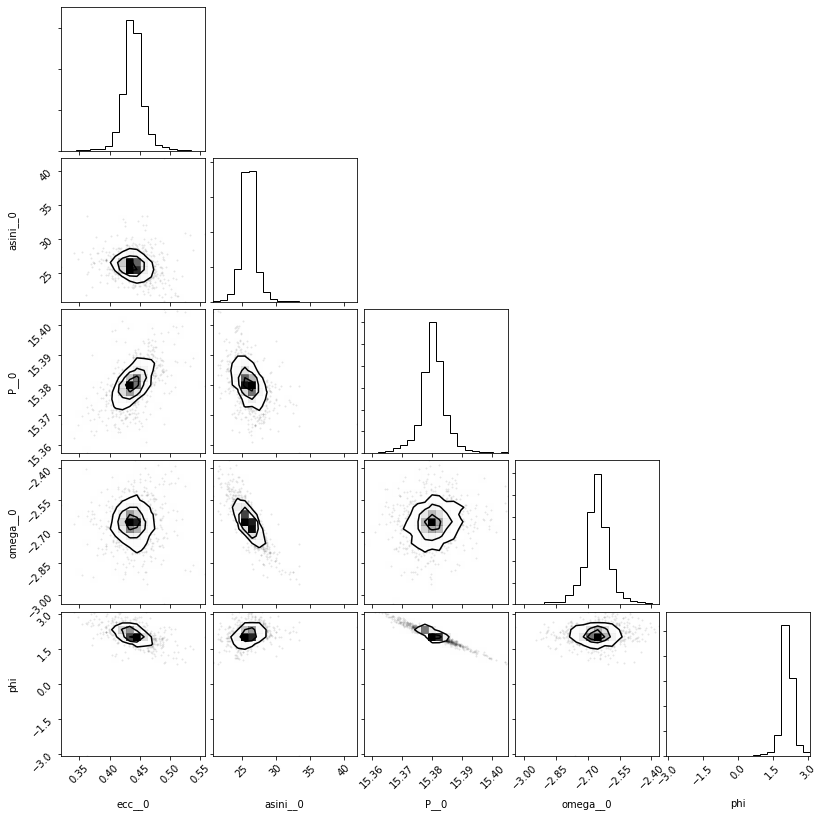

In [24]:
import corner

corner.corner(pm.trace_to_dataframe(trace, varnames=['ecc', 'asini', 'P', 'omega', 'phi']));

In [22]:
1/0.33

3.0303030303030303

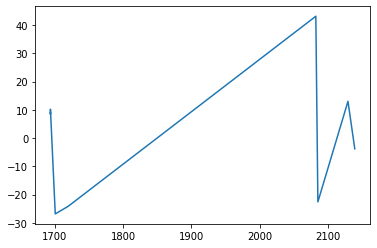

In [10]:
x, y, yerr = np.loadtxt('data/kic6780873_JDrv.txt', usecols=(0,1,2), delimiter=',').T
x += 2400000
x -= 2454833
plt.plot(x,y)
rv_jd, rv_rv = x, y

In [11]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import pymc3 as pm
import theano

rv_time_tensor = theano.shared(rv_jd)
rv_rv_tensor = theano.shared(rv_rv)

weight = True

with pm.Model() as model:
    logP = pm.Bound(pm.Normal,
                    lower=np.log(5),
                    upper=np.log(50))("logP", mu=np.log(9.15), sd=1.0,
                                      testval=np.log(9.15))
    period = pm.Deterministic("period", pm.math.exp(logP))
    # Time delay drift
#     drift_gradient = pm.Normal('drift_grad', mu=0.0, sd=0.01, shape=len(freq))
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi")
    logasini = pm.Bound(pm.Normal,
                        lower=np.log(10),
                        upper=np.log(50))('logasini', mu=np.log(19.6), sd=1,
                                            testval=np.log(19.6))
    asini = pm.Deterministic("asini", tt.exp(logasini))
    
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    
    
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega")
    #omega = pm.Uniform("omega", lower=0, upper=2*np.pi)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=1-1e-3, testval=0.003)
                
    
    # RADIAL VELOCITIES
    logs_rv = pm.Normal('logs_RV_a', mu=0., sd=10)
    gammav = pm.Normal('gammav', mu=0., sd=100.)
    rv_mean_anom = (2.0 * np.pi * rv_time_tensor / period - phi)
    rv_true_anom = get_true_anomaly(rv_mean_anom, eccen + tt.zeros_like(rv_mean_anom))
    
    rv_vrad_a = ((asini / 86400) * (-2.0 * np.pi * (1 / period) * 
                                    (1/tt.sqrt(1.0 - tt.square(eccen))) * (tt.cos(rv_true_anom + omega) + eccen*tt.cos(omega))))
    rv_vrad_a *= 299792.458  # c in km/s
    rv_vrad_a += gammav

    pm.Normal("obs_radial_velocity_a", mu=rv_vrad_a, sd=tt.exp(logs_rv), observed=rv_rv_tensor.get_value())
    

In [12]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_rv])
    map_params = xo.optimize(start=map_params, vars=[gammav])
    map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[logasini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)

[phi_angle__, mean, omega_angle__, eccen_interval__, logs_RV_a, gammav]


optimizing logp for variables: [mean]
7it [00:00,  7.99it/s, logp=-3.175982e+03] 
message: Optimization terminated successfully.
logp: -3175.9818350607516 -> -3175.9818350200603
optimizing logp for variables: [logs_RV_a]
16it [00:00, 218.08it/s, logp=-6.465911e+01]
message: Optimization terminated successfully.
logp: -3175.9818350200603 -> -64.6591059987102
optimizing logp for variables: [gammav]
8it [00:00, 120.32it/s, logp=-6.321143e+01] 
message: Optimization terminated successfully.
logp: -64.6591059987102 -> -63.211426536906814
optimizing logp for variables: [omega, eccen]
18it [00:00, 230.24it/s, logp=-3.609308e+01]
message: Optimization terminated successfully.
logp: -63.211426536906814 -> -36.09308447622425
optimizing logp for variables: [phi]
10it [00:00, 154.91it/s, logp=-1.562573e+01]
message: Optimization terminated successfully.
logp: -36.09308447622425 -> -15.625732310199453
optimizing logp for variables: [gammav, logs_RV_a, eccen, omega, mean, phi]
48it [00:00, 316.38it/

In [13]:
map_params

{'logP_interval__': array(-1.03326743),
 'phi_angle__': array([4.27363552, 1.31758784]),
 'logasini_interval__': array(-0.33908029),
 'mean': array(0.00031147),
 'omega_angle__': array([ 4.08030208, -1.83061017]),
 'eccen_interval__': array(-1.77755012),
 'logs_RV_a': array(0.07045314),
 'gammav': array(17.85483381),
 'logP': array(2.21375399),
 'period': array(9.15000098),
 'phi': array(1.2717368),
 'logasini': array(2.97216422),
 'asini': array(19.53415005),
 'omega': array(1.99252348),
 'eccen': array(0.1444613)}

In [14]:
np.random.seed(42)
with model:
    trace = pm.sample(tune=1000, draws=1000, step=xo.get_dense_nuts_step(target_accept=0.95))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [gammav, logs_RV_a, eccen, omega, mean, logasini, phi, logP]
Sampling 2 chains: 100%|██████████| 4000/4000 [07:04<00:00,  9.42draws/s]
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [15]:
pm.summary(trace)

/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.103485,10.228620,0.313928,-20.941466,19.387239,1082.498576,0.999726
logs_RV_a,0.099862,0.417137,0.022707,-0.654051,0.903698,224.359987,1.026493
gammav,7.000922,6.302968,0.537164,-6.035192,16.308731,39.108304,1.031119
logP,2.216061,0.001773,0.000153,2.213477,2.219739,35.099175,1.033961
period,9.171145,0.016272,0.001409,9.147466,9.204930,35.095917,1.033929
phi,-0.183577,1.446760,0.083585,-3.031682,2.480085,145.792081,1.006153
logasini,2.807754,0.074980,0.005589,2.633887,2.926291,99.625406,1.001335
asini,16.620184,1.287662,0.094636,13.927805,18.658300,110.393692,1.001429
omega,2.291318,1.205351,0.079326,-0.240192,3.136910,76.587524,1.026293
eccen,0.165982,0.108756,0.009189,0.000438,0.373322,35.663915,1.024514


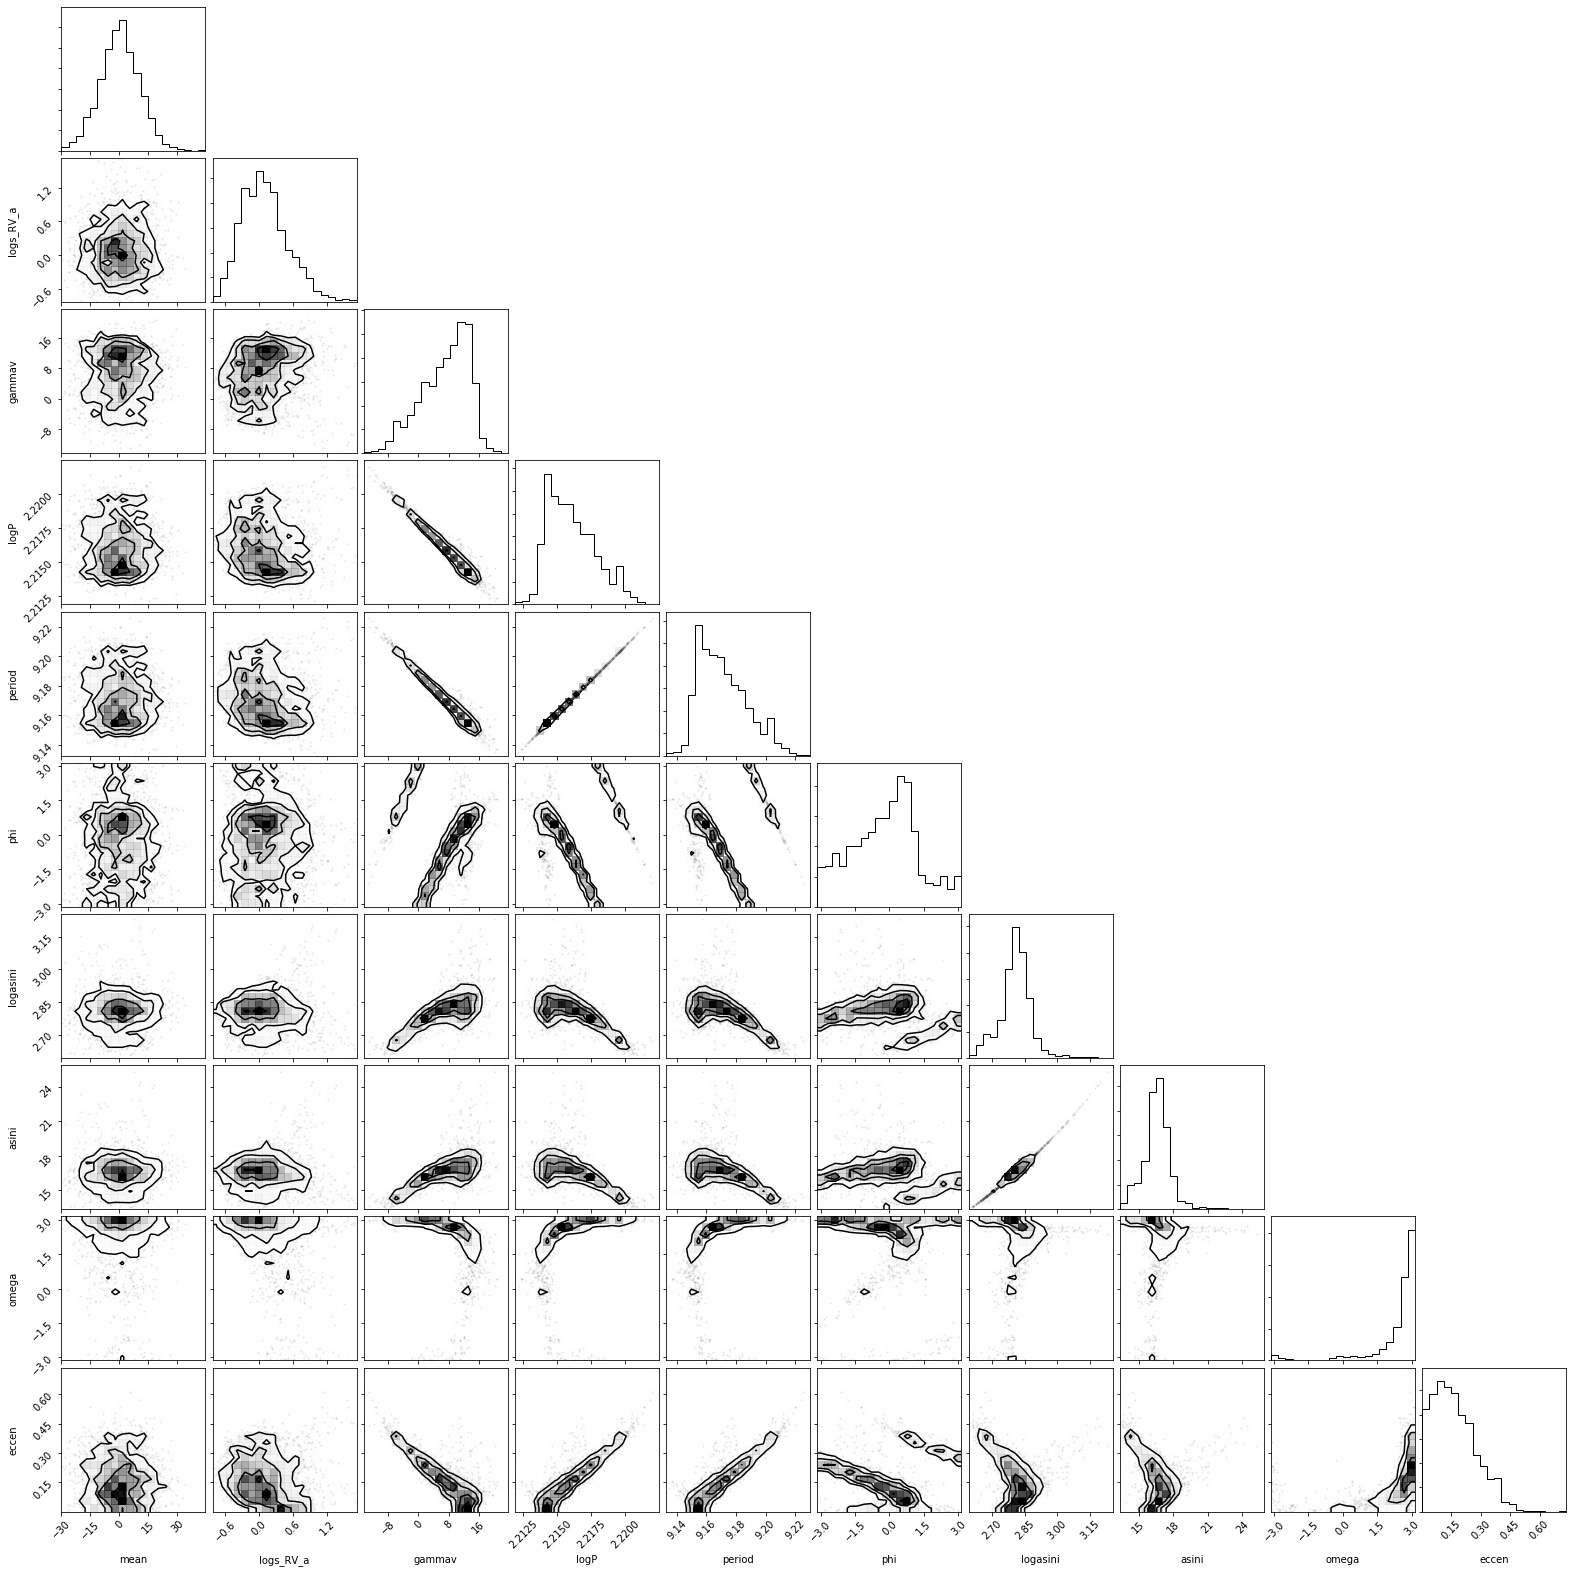

In [16]:
import corner

corner.corner(pm.trace_to_dataframe(trace));